## Imports

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
import astropy.units as u
from gaussian_process_example import *


df = pd.read_csv('gp_objects(downsample).csv')
obj = sorted(df.obj_id.unique())
df_observed = pd.read_csv('gp_objects_original_observations(matched).csv')
df_observed = df_observed[df_observed.obj_id.isin(obj)]
display(df)
display(df_observed)
common_columns = ['obj_id', 'type', 'redshift', 'mjd', 'mjd_0', 't', 'mag_ztfg',
    'abs_mag_ztfg', 'mag_error_ztfg', 'mag_ztfr', 'abs_mag_ztfr',
    'mag_error_ztfr', 'mag_ztfi', 'abs_mag_ztfi', 'mag_error_ztfi',]
filters = ['ztfg', 'ztfr', 'ztfi']

,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id,mjd_0,...,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi,t,rise,fade
0,57983.231000,385.374906,440.341788,404.940209,29.250027,17.182907,24.797305,Kilonova,AT2017gfo,57983.231000,...,0.082408,17.381523,-15.832157,0.066487,17.290525,-15.923154,0.042367,0.000000,n,y
1,57983.239778,382.559484,438.232033,402.502588,28.789575,16.890215,24.361032,Kilonova,AT2017gfo,57983.231000,...,0.081707,17.388078,-15.825601,0.065713,17.295740,-15.917940,0.041846,0.008778,n,y
2,57983.248556,379.738177,436.119876,400.065220,28.332873,16.606597,23.927709,Kilonova,AT2017gfo,57983.231000,...,0.081009,17.394673,-15.819007,0.064937,17.300985,-15.912694,0.041343,0.017556,n,y
3,57983.257333,376.910979,434.005567,397.628148,27.879986,16.332054,23.497397,Kilonova,AT2017gfo,57983.231000,...,0.080312,17.401307,-15.812372,0.064160,17.306262,-15.907418,0.040857,0.026333,n,y
4,57983.266111,374.077886,431.889351,395.191413,27.430981,16.066587,23.070161,Kilonova,AT2017gfo,57983.231000,...,0.079617,17.407981,-15.805698,0.063382,17.311569,-15.902111,0.040390,0.035111,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37853,60652.513689,33.493383,NaN,40.961798,3.488673,NaN,5.252959,IIb,ZTF24abvevzs,60646.432303,...,0.113090,19.869052,-16.140503,0.139235,NaN,NaN,NaN,6.081386,y,y
37854,60652.519801,33.463261,NaN,40.930338,3.842217,NaN,5.054402,IIb,ZTF24abvevzs,60646.432303,...,0.124663,19.869887,-16.139669,0.134075,NaN,NaN,NaN,6.087498,y,y
37855,60652.525913,33.432509,NaN,40.895906,4.235472,NaN,4.909244,IIb,ZTF24abvevzs,60646.432303,...,0.137549,19.870800,-16.138755,0.130334,NaN,NaN,NaN,6.093610,y,y
37856,60652.532025,33.401076,NaN,40.858402,4.657035,NaN,4.823773,IIb,ZTF24abvevzs,60646.432303,...,0.151382,19.871797,-16.137759,0.128183,NaN,NaN,NaN,6.099721,y,y


,obj_id,type,redshift,mjd,mjd_0,t,mag_ztfg,abs_mag_ztfg,mag_error_ztfg,mag_ztfr,abs_mag_ztfr,mag_error_ztfr,mag_ztfi,abs_mag_ztfi,mag_error_ztfi
0,AT2017gfo,Kilonova,0.00984,57983.231000,57983.231000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,17.24,-15.97368,0.06
1,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,17.460000,-15.753680,0.080000,NaN,NaN,NaN,NaN,NaN,NaN
2,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,17.32000,-15.893680,0.070000,NaN,NaN,NaN
3,AT2017gfo,Kilonova,0.00984,57983.420000,57983.231000,0.189000,NaN,NaN,NaN,NaN,NaN,NaN,17.42,-15.79368,0.05
4,AT2017gfo,Kilonova,0.00984,57983.758000,57983.231000,0.527000,18.050000,-15.163680,0.120000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,ZTF24abvevzs,IIb,0.03500,60650.533484,60646.432303,4.101181,19.486008,-16.523548,0.068334,NaN,NaN,NaN,NaN,NaN,NaN
9429,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068013,-15.941543,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9430,ZTF24abvevzs,IIb,0.03500,60652.490127,60646.432303,6.057824,20.068001,-15.941555,0.170292,NaN,NaN,NaN,NaN,NaN,NaN
9431,ZTF24abvevzs,IIb,0.03500,60652.491644,60646.432303,6.059340,20.109029,-15.900527,0.140443,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
len(df.obj_id.unique())

70

In [3]:
df_rates = pd.DataFrame()
df_rates['obj_id'] = df.obj_id.unique()

In [4]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,36858.000000,37858.000000,13666.000000
mean,0.415769,0.264926,0.316735
std,106.366928,6.521200,3.073086
min,-1228.832172,-355.417462,-312.833651
25%,0.066561,0.065269,0.117106
50%,0.137652,0.116785,0.218006
75%,0.337739,0.210678,0.390698
max,17819.057210,1121.578537,116.527049


mag_error_ztfg    0.491751
mag_error_ztfr    0.334565
mag_error_ztfi    0.515876
Name: 0.85, dtype: float64

mag_error_ztfg    1.176517
mag_error_ztfr    0.693106
mag_error_ztfi    0.881413
Name: 0.95, dtype: float64

mag_error_ztfg    4.345571
mag_error_ztfr    2.624724
mag_error_ztfi    1.980293
Name: 0.99, dtype: float64


Filtering out the high error data/data that has errors that don't make sense

In [5]:
for item in ['ztfg','ztfr','ztfi']:
    df.loc[df[f'mag_error_{item}'] < 0, f'mag_error_{item}'] = np.nan
    df.loc[df[f'mag_error_{item}'] > 1, f'mag_error_{item}'] = np.nan

In [6]:
display(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].describe())
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.85))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.95))
print()
print(df[['mag_error_ztfg','mag_error_ztfr','mag_error_ztfi']].quantile(0.99))

,mag_error_ztfg,mag_error_ztfr,mag_error_ztfi
count,33886.000000,36410.000000,13118.000000
mean,0.203838,0.161799,0.265050
std,0.188974,0.154739,0.197895
min,0.006692,0.007899,0.010117
25%,0.066413,0.063897,0.116101
50%,0.129945,0.113161,0.205841
75%,0.290533,0.195354,0.367909
max,0.999976,0.999657,0.999118


mag_error_ztfg    0.396020
mag_error_ztfr    0.278277
mag_error_ztfi    0.453800
Name: 0.85, dtype: float64

mag_error_ztfg    0.609745
mag_error_ztfr    0.526116
mag_error_ztfi    0.689818
Name: 0.95, dtype: float64

mag_error_ztfg    0.860521
mag_error_ztfr    0.731955
mag_error_ztfi    0.894829
Name: 0.99, dtype: float64


In [7]:
# for obj_i in obj:
#     # print(obj_i)
#     df_obj = df[df.obj_id == obj_i]
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in ['ztfg', 'ztfr', 'ztfi']:
#         # df_det = df_observed[(df_observed.obj_id == obj_i) & (df_observed.filter == filter) & (df_observed.t < df_obj.t.max())]
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
#         # ax.scatter(df_det.t, df_det.absmag, c='r', s=100)
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

## Rate Calculations

In [8]:
def calc_peak(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the peak magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    peak_dict: dictionary of peak values/times with filters as keys. Order is (t,value)
    '''
    peak_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            peak = df[df[mag] == df[mag].min()]
            if len(peak) > 0:
                peak = peak.iloc[0]
                peak_dict[filt] = (peak['t'], peak[mag])
                
    return peak_dict

def calc_fwhm(df, abs=True, filters=['ztfg','ztfr','ztfi'], mag_diff=-2.5*np.log10(0.5), extrapolate=True):
    '''
    Calculates the full width at half maximum in a given set of filters and returns them as a dictionary containing the time duration and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    mag_diff: the difference in magnitude between the peak and the half maximum value. Default is -2.5*np.log10(0.5) (corresponds to half the flux)
    extrapolate (bool): whether to extrapolate the fwhm value if there is not both a rise and fade in the data. If set to true and, for example, there is only a fade, the function will extrapolate the fwhm value by assuming the rise time is equal to the fade time
    
    Returns
    fwhm_dict: dictionary of fwhm duration with filters as keys.
    rise_hwhm_dict: dictionary of duration of time above half maximum before the peak with filters as keys.
    fade_hwhm_dict: dictionary of duration of time above half maximum after the peak with filters as keys.
    fade_hwhm_dict: dictionary of peak times with filters as keys.
    '''
    fwhm_dict = {filter: np.nan for filter in filters}
    rise_hwhm_dict = {filter: np.nan for filter in filters}
    fade_hwhm_dict = {filter: np.nan for filter in filters}
    peak_dict = calc_peak(df, abs=abs, filters=filters)
    
    print(df.obj_id.iloc[0])
    for filter_ in filters:
        if abs:
            mag = 'abs_mag_' + filter_
        else:
            mag = 'mag_' + filter_
        
        if mag in df.columns:
            peak = peak_dict[filter_]
            if peak[0] is not np.nan:
                half_peak = peak[1] + mag_diff
                df_filter = df[df[mag].notnull()]
                df_rise = df_filter[df_filter['t'] <= peak[0]]
                df_fade = df_filter[df_filter['t'] >= peak[0]]
                
                rise = df_rise[df_rise[mag] < half_peak]
                rise_fwhm_time = peak[0] - rise.iloc[0]['t']
                rise_hwhm_dict[filter_] = rise_fwhm_time
                fade = df_fade[df_fade[mag] < half_peak]
                fade_fwhm_time = fade.iloc[-1]['t'] - peak[0]
                fade_hwhm_dict[filter_] = fade_fwhm_time
                
                if rise_fwhm_time != 0 and fade_fwhm_time != 0:
                    fwhm_dict[filter_] = rise_fwhm_time + fade_fwhm_time
                else:
                    fwhm_dict[filter_] = np.nan
                    if extrapolate:
                        if rise_fwhm_time != 0 and fade_fwhm_time == 0:
                            fwhm_dict[filter_] = rise_fwhm_time * 2
                        elif fade_fwhm_time != 0 and rise_fwhm_time == 0:
                            fwhm_dict[filter_] = fade_fwhm_time * 2
                
    ## set any values that are 0 to be np.nan
    for filter_ in filters:
        if fwhm_dict[filter_] == 0:
            fwhm_dict[filter_] = np.nan
        if rise_hwhm_dict[filter_] == 0:
            rise_hwhm_dict[filter_] = np.nan
        if fade_hwhm_dict[filter_] == 0:
            fade_hwhm_dict[filter_] = np.nan
    
    return fwhm_dict, rise_hwhm_dict, fade_hwhm_dict


def calc_min(df, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the minimum magntitude in a given set of filters and returns them as a dictionary containing the time and value
    
    Args:
    df: dataframe
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    min_dict: dictionary of min values/times with filters as keys. Order is (t,value)
    '''
    min_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            min = df[df[mag] == df[mag].max()]
            if len(min) > 0:
                min = min.iloc[0]
                min_dict[filt] = (min['t'], min[mag])
                
    return min_dict

def calc_rate(df, interval_dict, abs=True, filters=['ztfg','ztfr','ztfi']):
    '''
    Calculates the rate of change in a given set of filters and returns them as a dictionary containing the time duration and value
    
    Args:
    df: dataframe
    interval_dict: time interval to calculate rate of change for each filter
    abs: use absolute magnitude
    filters: list of filters to search for. Default behavior searches for all ztf filters. Function will not fail if the dataframe does not contain that filter
    
    Returns
    rate_dict: dictionary of rate values/times with filters as keys. Order is (t,value)
    '''
    rate_dict = {filter: (np.nan,np.nan) for filter in filters}
    for filt in filters:
        interval = interval_dict[filt]
        if abs:
            mag = 'abs_mag_' + filt
        else:
            mag = 'mag_' + filt
        
        if mag in df.columns:
            df_filter = df[df[mag].notnull()]
            df_rate = df_filter[(df_filter['t'] >= interval[0]) & (df_filter['t'] <= interval[1])]
            time_interval = df_rate['t'].max() - df_rate['t'].min()
            if time_interval > 0:
                mag_interval = df_rate.iloc[-1][mag] - df_rate.iloc[0][mag] 
                # print(mag_interval)
                # mag_interval = df_rate[mag].loc[df_rate['t'].idxmax()] - df_rate[mag].loc[df_rate['t'].idxmin()]
                rate_dict[filt] = (time_interval, mag_interval/time_interval)
    
    return rate_dict
            

In [9]:
# # Iterate over each object in the dataframe
# for obj_i in obj:
#     df_obj = df[df.obj_id == obj_i]
#     min_dict = calc_peak(df_obj)
    
#     fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#     for filter in filters:
#         ax.fill_between(df_obj.t, df_obj[f'abs_mag_{filter}'] - df_obj[f'mag_error_{filter}'], df_obj[f'abs_mag_{filter}'] + df_obj[f'mag_error_{filter}'], alpha=0.3)
#         ax.plot(df_obj.t, df_obj[f'abs_mag_{filter}'], label=filter)
        
#         # Plot vertical lines at min magnitudes
#         min_time, min_mag = min_dict[filter]
#         if min_time is not None:
#             ax.axvline(x=min_time, color='r', linestyle='--')
#             ax.text(min_time, min_mag, f'{filter} min', rotation=90, verticalalignment='bottom')
    
#     ax.invert_yaxis()
#     ax.legend()
#     obj_id = df_obj['obj_id'].iloc[0]
#     obj_type = df_obj['type'].iloc[0]
#     ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_type}')
#     plt.show()

#### Peak Values

In [10]:
df_rise = df[df.rise == 'y']

## identify the times of the peak in each filter for each object
df_peak = df.groupby('obj_id').apply(calc_peak)
df_peak = pd.DataFrame(df_peak.to_list(), index=df_peak.index)
df_peak = df_peak.reset_index()

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_peak[f'{filt}_peak_time'] = df_peak[f'{filt}'].apply(lambda x: x[0])
    df_peak[f'{filt}_peak_mag'] = df_peak[f'{filt}'].apply(lambda x: x[1])

    df_peak.drop(columns=[f'{filt}'], inplace=True)
df_peak


,obj_id,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag
0,AT2017gfo,0.000000,-15.778388,0.000000,-15.832157,0.000000,-15.923154
1,ZTF18aakuewf,3.898491,-19.662041,4.198375,-19.545710,NaN,NaN
2,ZTF18aalrxas,1.961364,-18.241097,2.059432,-17.955813,NaN,NaN
3,ZTF18abffyqp,0.950871,-17.541600,2.502293,-17.327431,NaN,NaN
4,ZTF18abvkmgw,4.277578,-17.382398,4.730358,-17.389784,NaN,NaN
...,...,...,...,...,...,...,...
65,ZTF23abobwsd,0.000000,-17.108568,0.000000,-17.180304,0.000000,-17.100538
66,ZTF23absbqun,1.853466,-14.354963,1.846337,-15.071233,NaN,NaN
67,ZTF23abtycgb,0.000000,-15.654520,0.000000,-15.700839,NaN,NaN
68,ZTF24aascytf,0.931519,-17.437112,1.269422,-17.117116,1.589061,-16.796361


Color at ztfg peak

In [11]:
df_ztfg_peak_color = pd.DataFrame()
df_ztfg_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfg_peak_color_dict = {}
for obj in df_ztfg_peak_color['obj_id']:
    obj_ztfg_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfg_peak_time = df_obj['ztfg_peak_time'].iloc[0]
    if ztfg_peak_time != None and ztfg_peak_time == ztfg_peak_time:
        ztfg_peak_row = df[(df.obj_id == obj) & (df.t == ztfg_peak_time)]
        obj_ztfg_peak_color_dict['ztfr'] = ztfg_peak_row['abs_mag_ztfg'].iloc[0] - ztfg_peak_row['abs_mag_ztfr'].iloc[0]
        obj_ztfg_peak_color_dict['ztfi'] = ztfg_peak_row['abs_mag_ztfg'].iloc[0] - ztfg_peak_row['abs_mag_ztfi'].iloc[0]

    else:
        for filt in ['ztfr', 'ztfi']:
            obj_ztfg_peak_color_dict[filt] = np.nan
    ztfg_peak_color_dict[obj] = obj_ztfg_peak_color_dict     

In [12]:
df_ztfg_peak_color = pd.DataFrame(ztfg_peak_color_dict).T.rename(columns={'ztfr': 'ztfg_peak_gr_color', 'ztfi': 'ztfg_peak_gi_color'}).reset_index()
df_ztfg_peak_color['obj_id'] = df_ztfg_peak_color['index']
df_ztfg_peak_color.drop(columns=['index'], inplace=True)

df_ztfg_peak_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id
0,0.053769,0.144766,AT2017gfo
1,-0.123851,NaN,ZTF18aakuewf
2,-0.285946,NaN,ZTF18aalrxas
3,-0.266512,NaN,ZTF18abffyqp
4,-0.003031,NaN,ZTF18abvkmgw
...,...,...,...
65,0.071736,-0.008030,ZTF23abobwsd
66,0.716266,NaN,ZTF23absbqun
67,0.046319,NaN,ZTF23abtycgb
68,-0.367762,-0.769678,ZTF24aascytf


Color at ztfr peak

In [13]:
df_ztfr_peak_color = pd.DataFrame()
df_ztfr_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfr_peak_color_dict = {}
for obj in df_ztfr_peak_color['obj_id']:
    obj_ztfr_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfr_peak_time = df_obj['ztfr_peak_time'].iloc[0]
    if ztfr_peak_time != None and ztfr_peak_time == ztfr_peak_time:
        ztfr_peak_row = df[(df.obj_id == obj) & (df.t == ztfr_peak_time)]
        obj_ztfr_peak_color_dict['ztfg'] = ztfr_peak_row[f'abs_mag_ztfg'].iloc[0] - ztfr_peak_row[f'abs_mag_ztfr'].iloc[0]
        obj_ztfr_peak_color_dict['ztfi'] = ztfr_peak_row[f'abs_mag_ztfr'].iloc[0] - ztfr_peak_row[f'abs_mag_ztfi'].iloc[0]
    else:
        for filt in ['ztfg', 'ztfi']:
            obj_ztfr_peak_color_dict[filt] = np.nan
    ztfr_peak_color_dict[obj] = obj_ztfr_peak_color_dict     

In [14]:
df_ztfr_peak_color = pd.DataFrame(ztfr_peak_color_dict).T.rename(columns={'ztfg': 'ztfr_peak_gr_color', 'ztfi': 'ztfr_peak_ri_color'}).reset_index()
df_ztfr_peak_color['obj_id'] = df_ztfr_peak_color['index']
df_ztfr_peak_color.drop(columns=['index'], inplace=True)

df_ztfr_peak_color

,ztfr_peak_gr_color,ztfr_peak_ri_color,obj_id
0,0.053769,0.090997,AT2017gfo
1,-0.113853,NaN,ZTF18aakuewf
2,-0.281763,NaN,ZTF18aalrxas
3,-0.142351,NaN,ZTF18abffyqp
4,0.018309,NaN,ZTF18abvkmgw
...,...,...,...
65,0.071736,-0.079765,ZTF23abobwsd
66,0.716282,NaN,ZTF23absbqun
67,0.046319,NaN,ZTF23abtycgb
68,-0.247112,-0.351021,ZTF24aascytf


Color at ztfi peak

In [15]:
df_ztfi_peak_color = pd.DataFrame()
df_ztfi_peak_color['obj_id'] = df_peak.obj_id.unique()
ztfi_peak_color_dict = {}
for obj in df_ztfi_peak_color['obj_id']:
    obj_ztfi_peak_color_dict = {}
    df_obj = df_peak[df_peak.obj_id == obj]
    ztfi_peak_time = df_obj['ztfi_peak_time'].iloc[0]
    if ztfi_peak_time != None and ztfi_peak_time == ztfi_peak_time:
        ztfi_peak_row = df[(df.obj_id == obj) & (df.t == ztfi_peak_time)]
        obj_ztfi_peak_color_dict['ztfg'] = ztfi_peak_row[f'abs_mag_ztfg'].iloc[0] - ztfi_peak_row[f'abs_mag_ztfi'].iloc[0]
        obj_ztfi_peak_color_dict['ztfr'] = ztfi_peak_row[f'abs_mag_ztfr'].iloc[0] - ztfi_peak_row[f'abs_mag_ztfi'].iloc[0]

    else:
        for filt in ['ztfg', 'ztfr']:
            obj_ztfi_peak_color_dict[filt] = np.nan
    ztfi_peak_color_dict[obj] = obj_ztfi_peak_color_dict     

In [16]:
df_ztfi_peak_color = pd.DataFrame(ztfi_peak_color_dict).T.rename(columns={'ztfg': 'ztfi_peak_gi_color', 'ztfr': 'ztfi_peak_ri_color'}).reset_index()
df_ztfi_peak_color['obj_id'] = df_ztfi_peak_color['index']
df_ztfi_peak_color.drop(columns=['index'], inplace=True)

df_ztfi_peak_color

,ztfi_peak_gi_color,ztfi_peak_ri_color,obj_id
0,0.144766,0.090997,AT2017gfo
1,NaN,NaN,ZTF18aakuewf
2,NaN,NaN,ZTF18aalrxas
3,NaN,NaN,ZTF18abffyqp
4,NaN,NaN,ZTF18abvkmgw
...,...,...,...
65,-0.008030,-0.079765,ZTF23abobwsd
66,NaN,NaN,ZTF23absbqun
67,NaN,NaN,ZTF23abtycgb
68,-0.441855,-0.279978,ZTF24aascytf


In [17]:
df_color = pd.merge(df_ztfg_peak_color, df_ztfr_peak_color, on='obj_id')
df_color = pd.merge(df_color, df_ztfi_peak_color, on='obj_id')
df_color

,ztfg_peak_gr_color,ztfg_peak_gi_color,obj_id,ztfr_peak_gr_color,ztfr_peak_ri_color,ztfi_peak_gi_color,ztfi_peak_ri_color
0,0.053769,0.144766,AT2017gfo,0.053769,0.090997,0.144766,0.090997
1,-0.123851,NaN,ZTF18aakuewf,-0.113853,NaN,NaN,NaN
2,-0.285946,NaN,ZTF18aalrxas,-0.281763,NaN,NaN,NaN
3,-0.266512,NaN,ZTF18abffyqp,-0.142351,NaN,NaN,NaN
4,-0.003031,NaN,ZTF18abvkmgw,0.018309,NaN,NaN,NaN
...,...,...,...,...,...,...,...
65,0.071736,-0.008030,ZTF23abobwsd,0.071736,-0.079765,-0.008030,-0.079765
66,0.716266,NaN,ZTF23absbqun,0.716282,NaN,NaN,NaN
67,0.046319,NaN,ZTF23abtycgb,0.046319,NaN,NaN,NaN
68,-0.367762,-0.769678,ZTF24aascytf,-0.247112,-0.351021,-0.441855,-0.279978


#### Full-Width at Half-Max

In [18]:
fwhm_dict = {}
rise_hwhm_dict = {}
fade_hwhm_dict = {}
for obj in df.obj_id.unique():
    df_obj = df[df.obj_id == obj]
    fwhm_dict[obj], rise_hwhm_dict[obj], fade_hwhm_dict[obj] = calc_fwhm(df_obj)

AT2017gfo
ZTF18aakuewf
ZTF18aalrxas
ZTF18abffyqp
ZTF18abvkmgw
ZTF18abwkrbl
ZTF19aanbpus
ZTF19aapfmki
ZTF19aatesgp
ZTF19abacxod
ZTF19abxjrge
ZTF19abxtcio
ZTF19abyjzvd
ZTF19acbumks
ZTF19accjfgv
ZTF20aahfqpm
ZTF20aajnksq
ZTF20aaxhzhc
ZTF20aayrobw
ZTF20aazchcq
ZTF20abstsxb
ZTF20aburywx
ZTF20abwzqzo
ZTF20acgigfo
ZTF20acgiglu
ZTF20acigusw
ZTF20aclfmwn
ZTF20acozryr
ZTF20acqntkr
ZTF20actqnhg
ZTF21aaabrpu
ZTF21aaabwfu
ZTF21aabxjqr
ZTF21aagwbjr
ZTF21aapkbav
ZTF21aaqzrat
ZTF21abbvvmf
ZTF21abexegc
ZTF21abfmpwn
ZTF21abhywxv
ZTF21aciosfu
ZTF22aaajecp
ZTF22aabjpxh
ZTF22aahgvlx
ZTF22aaibbvy
ZTF22aajrrzz
ZTF22aayluxo
ZTF22aazmooy
ZTF22abfjnpj
ZTF22abfxmpc
ZTF22abijszk
ZTF22abmsaxp
ZTF22abuzpzz
ZTF23aadhssd
ZTF23aaemgsd
ZTF23aaeozpp
ZTF23aaikakr
ZTF23aajadma
ZTF23aaoohpy
ZTF23aarlxdf
ZTF23aaxeacr
ZTF23aaxzvrr
ZTF23abgsmsg
ZTF23abjwgre
ZTF23abnpdod
ZTF23abobwsd
ZTF23absbqun
ZTF23abtycgb
ZTF24aascytf
ZTF24abvevzs


In [19]:
df_fwhm = pd.DataFrame(fwhm_dict).T.rename(columns={'ztfg': 'ztfg_fwhm', 'ztfr': 'ztfr_fwhm', 'ztfi': 'ztfi_fwhm'}).reset_index()
df_rise_hwhm = pd.DataFrame(rise_hwhm_dict).T.rename(columns={'ztfg': 'ztfg_rise_hwhm', 'ztfr': 'ztfr_rise_hwhm', 'ztfi': 'ztfi_rise_hwhm'}).reset_index()
df_fade_hwhm = pd.DataFrame(fade_hwhm_dict).T.rename(columns={'ztfg': 'ztfg_fade_hwhm', 'ztfr': 'ztfr_fade_hwhm', 'ztfi': 'ztfi_fade_hwhm'}).reset_index()
df_fwhm = pd.merge(df_fwhm, df_rise_hwhm, on='index')
df_fwhm = pd.merge(df_fwhm, df_fade_hwhm, on='index')
df_fwhm['obj_id'] = df_fwhm['index']
df_fwhm.drop(columns=['index'], inplace=True)
df_fwhm

,ztfg_fwhm,ztfr_fwhm,ztfi_fwhm,ztfg_rise_hwhm,ztfr_rise_hwhm,ztfi_rise_hwhm,ztfg_fade_hwhm,ztfr_fade_hwhm,ztfi_fade_hwhm,obj_id
0,1.158667,1.808222,2.089111,NaN,NaN,NaN,0.579333,0.904111,1.044556,AT2017gfo
1,9.396363,9.096479,NaN,3.548626,3.448665,NaN,5.847736,5.647814,NaN,ZTF18aakuewf
2,4.560171,6.619602,NaN,1.961364,2.059432,NaN,2.598807,4.560171,NaN,ZTF18aalrxas
3,6.606055,9.959128,NaN,0.950871,2.502293,NaN,5.655183,7.456834,NaN,ZTF18abffyqp
4,9.794344,10.473514,NaN,3.014561,3.300527,NaN,6.779783,7.172987,NaN,ZTF18abvkmgw
...,...,...,...,...,...,...,...,...,...,...
65,12.696471,15.916591,15.916591,NaN,NaN,NaN,6.348236,7.958295,7.958295,ZTF23abobwsd
66,4.220199,5.118417,NaN,1.853466,1.846337,NaN,2.366733,3.272080,NaN,ZTF23absbqun
67,2.172578,3.504158,NaN,NaN,NaN,NaN,1.086289,1.752079,NaN,ZTF23abtycgb
68,2.438387,3.059399,3.990918,0.931519,1.269422,1.589061,1.506868,1.789977,2.401857,ZTF24aascytf


#### Rise Rates

In [20]:
riserate_dict = {}
for obj_i in df_rise.obj_id.unique():
    df_obj = df_rise[df_rise.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    
    ## cut off the light curve past the peak time for each filter
    for filter in filters:
        min_time, min_mag = peak_dict[filter]
        if min_time is not None:
            df_obj.loc[df_obj.t > min_time, f'abs_mag_{filter}'] = np.nan
            df_obj.loc[df_obj.t > min_time, f'mag_error_{filter}'] = np.nan
    interval_dict = {filter: (df_obj.t.min(), peak_dict[filter][0]) for filter in filters}
    rate_dict = calc_rate(df_obj, interval_dict)
    riserate_dict[obj_i] = rate_dict

In [21]:
df_riserate = pd.DataFrame(riserate_dict).T.rename(columns={'ztfg': 'ztfg_rise', 'ztfr': 'ztfr_rise', 'ztfi': 'ztfi_rise'}).reset_index()
df_riserate['obj_id'] = df_riserate['index']
df_riserate.drop(columns=['index'], inplace=True)

for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_riserate[f'{filt}_rise_duration'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[0])
    df_riserate[f'{filt}_rise_rate'] = df_riserate[f'{filt}_rise'].apply(lambda x: x[1])
    df_riserate.drop(columns=[f'{filt}_rise'], inplace=True)


df_riserate

,obj_id,ztfg_rise_duration,ztfg_rise_rate,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate
0,ZTF18aakuewf,3.898491,-0.224093,4.198375,-0.263379,NaN,NaN
1,ZTF18aalrxas,1.961364,-0.347917,2.059432,-0.255473,NaN,NaN
2,ZTF18abffyqp,0.950871,-0.022055,2.502293,-0.051043,NaN,NaN
3,ZTF18abvkmgw,4.277578,-0.375830,4.730358,-0.339628,NaN,NaN
4,ZTF18abwkrbl,2.837926,-0.682061,3.620802,-0.485527,NaN,NaN
5,ZTF19aapfmki,3.675950,-0.087083,3.994339,-0.063915,NaN,NaN
6,ZTF19aatesgp,6.605405,-0.661647,5.504504,-0.369039,6.104995,-0.099476
7,ZTF19abxtcio,13.868424,-0.036465,15.104224,-0.071414,NaN,NaN
8,ZTF19abyjzvd,2.963563,-0.043346,3.454153,-0.035751,NaN,NaN
9,ZTF19acbumks,3.267955,-0.175060,3.340577,-0.191421,NaN,NaN


In [22]:
df_riserate['ztfg_rise_duration'].describe()

count    34.000000
mean      5.862052
std       6.359421
min       0.244034
25%       1.558149
50%       2.900744
75%       8.480008
max      22.508858
Name: ztfg_rise_duration, dtype: float64

#### Fade Rates

In [23]:
len(df[df.rise == 'n'][df.fade== 'y'].obj_id.unique())

/tmp/ipykernel_44313/2926404735.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df.rise == 'n'][df.fade== 'y'].obj_id.unique())


36

In [24]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2 ## calculating fade rate between the peak and 2 days after the peak
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict


In [25]:
df_faderate = pd.DataFrame(faderate_dict).T.rename(columns={'ztfg': 'ztfg_fade', 'ztfr': 'ztfr_fade', 'ztfi': 'ztfi_fade'})
df_faderate.reset_index(inplace=True)
df_faderate['obj_id'] = df_faderate['index']
df_faderate.drop(columns=['index'], inplace=True)
for filt in ['ztfg', 'ztfr', 'ztfi']:
    df_faderate[f'{filt}_fade_duration'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[0])
    df_faderate[f'{filt}_fade_rate'] = df_faderate[f'{filt}_fade'].apply(lambda x: x[1])
    df_faderate.drop(columns=[f'{filt}_fade'], inplace=True)
df_faderate

,obj_id,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,AT2017gfo,1.992556,1.468151,1.992556,0.936347,1.992556,0.657337
1,ZTF18aakuewf,1.999226,0.049847,1.999226,0.091061,NaN,NaN
2,ZTF18aalrxas,1.961364,0.269659,1.961364,0.136353,NaN,NaN
3,ZTF18abffyqp,1.951789,0.057264,1.951789,0.041668,NaN,NaN
4,ZTF18abvkmgw,1.989848,0.074062,1.989848,0.042339,NaN,NaN
...,...,...,...,...,...,...,...
62,ZTF23abobwsd,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
63,ZTF23absbqun,1.996040,0.270486,1.996040,0.144054,NaN,NaN
64,ZTF23abtycgb,1.997370,0.610436,1.997370,0.424219,NaN,NaN
65,ZTF24aascytf,1.990893,0.622009,1.990893,0.441016,1.990893,0.286326


In [26]:
df_fade = df[df.fade == 'y']
rise_and_fade_objects = df[(df.rise =='y') & (df.fade == 'y')].obj_id.unique()

faderate_dict = {}
for obj_i in df_fade.obj_id.unique():
    df_obj = df_fade[df_fade.obj_id == obj_i]
    peak_dict = calc_peak(df_obj)
    interval_dict = {}
    for filt in ['ztfg', 'ztfr', 'ztfi']:
        min_time, min_mag = peak_dict[filt]
        if min_time is not None:
            start_time, end_time = min_time, min_time+2
            interval_dict[filt] = (start_time, end_time)
        else:
            interval_dict[filt] = (np.nan, np.nan)
    #interval_dict = {filter: (peak_dict[filter][0], peak_dict[filter][0]+2) for filter in filters}
    
    if obj_i == 'ZTF21aaabrpu': ## this one is weird about the peak time, and the ztfg is rising while the other two are falling
        ztfr_first_datapoint = df_obj[df_obj.abs_mag_ztfr.notnull()].iloc[0]
        ztfr_first_datapoint_mag = ztfr_first_datapoint.abs_mag_ztfr
        ztfr_first_datapoint_time = ztfr_first_datapoint.t
        ztfi_first_datapoint = df_obj[df_obj.abs_mag_ztfi.notnull()].iloc[0]
        ztfi_first_datapoint_mag = ztfi_first_datapoint.abs_mag_ztfi
        ztfi_first_datapoint_time = ztfi_first_datapoint.t
        interval_dict = {'ztfg':(np.nan,np.nan), 
                         'ztfr':(ztfr_first_datapoint_time, ztfr_first_datapoint_time+2), 
                         'ztfi':(ztfi_first_datapoint_time, ztfi_first_datapoint_time+2)}
    rate_dict = calc_rate(df_obj, interval_dict)
    faderate_dict[obj_i] = rate_dict

##### Combining Metrics into one DataFrame

In [27]:
## to categorize objects for radio plot
categories_dict = {
    'Kilonova': 'Kilonova',
    'Afterglow': 'Afterglow',
    'IIb': 'IIb',
    'Ibn': 'Misc SNe',
    'II': 'Misc SNe',
    'Ib': 'Misc SNe',
    'Ic-BL': 'Misc SNe',
    'Ia': 'Misc SNe',
    'Ib/c;Ib-pec': 'Misc SNe',
    'IIP': 'Misc SNe',
    'Novae': 'Galactic',
    'Cataclysmic': 'Galactic',
    'TDE': 'Other',
    'FBOT': 'Other',
}

In [28]:
df_rates =  df_peak.merge(df_color, on='obj_id', how='outer').merge(df_fwhm, on='obj_id', how='outer').merge(df_riserate, on='obj_id', how='outer').merge(df_faderate, on='obj_id', how='outer')
df_rates['type'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].type.iloc[0])
df_rates['redshift'] = df_rates['obj_id'].apply(lambda x: df[df.obj_id == x].redshift.iloc[0])
df_rates['category'] = df_rates['type'].apply(lambda x: categories_dict[x])
df_rates_columns_ = df_rates.columns.tolist()
# print(df_rates_columns_ )
df_rates_columns_ = ['obj_id', 'type','category', 'redshift'] + df_rates_columns_[1:-3]
df_rates = df_rates[df_rates_columns_] ## reordering columns
df_rates

,obj_id,type,category,redshift,ztfg_peak_time,ztfg_peak_mag,ztfr_peak_time,ztfr_peak_mag,ztfi_peak_time,ztfi_peak_mag,...,ztfr_rise_duration,ztfr_rise_rate,ztfi_rise_duration,ztfi_rise_rate,ztfg_fade_duration,ztfg_fade_rate,ztfr_fade_duration,ztfr_fade_rate,ztfi_fade_duration,ztfi_fade_rate
0,AT2017gfo,Kilonova,Kilonova,0.009840,0.000000,-15.778388,0.000000,-15.832157,0.000000,-15.923154,...,NaN,NaN,NaN,NaN,1.992556,1.468151,1.992556,0.936347,1.992556,0.657337
1,ZTF18aakuewf,Ibn,Misc SNe,0.063600,3.898491,-19.662041,4.198375,-19.545710,NaN,NaN,...,4.198375,-0.263379,NaN,NaN,1.999226,0.049847,1.999226,0.091061,NaN,NaN
2,ZTF18aalrxas,IIb,IIb,0.058200,1.961364,-18.241097,2.059432,-17.955813,NaN,NaN,...,2.059432,-0.255473,NaN,NaN,1.961364,0.269659,1.961364,0.136353,NaN,NaN
3,ZTF18abffyqp,II,Misc SNe,0.031000,0.950871,-17.541600,2.502293,-17.327431,NaN,NaN,...,2.502293,-0.051043,NaN,NaN,1.951789,0.057264,1.951789,0.041668,NaN,NaN
4,ZTF18abvkmgw,Ib,Misc SNe,0.038470,4.277578,-17.382398,4.730358,-17.389784,NaN,NaN,...,4.730358,-0.339628,NaN,NaN,1.989848,0.074062,1.989848,0.042339,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,ZTF23abobwsd,IIb,IIb,0.024000,0.000000,-17.108568,0.000000,-17.180304,0.000000,-17.100538,...,NaN,NaN,NaN,NaN,1.978073,0.112160,1.978073,0.061998,1.978073,0.019844
66,ZTF23absbqun,Ib,Misc SNe,0.010100,1.853466,-14.354963,1.846337,-15.071233,NaN,NaN,...,1.846337,-0.095967,NaN,NaN,1.996040,0.270486,1.996040,0.144054,NaN,NaN
67,ZTF23abtycgb,II,Misc SNe,0.020127,0.000000,-15.654520,0.000000,-15.700839,NaN,NaN,...,NaN,NaN,NaN,NaN,1.997370,0.610436,1.997370,0.424219,NaN,NaN
68,ZTF24aascytf,II,Misc SNe,0.038000,0.931519,-17.437112,1.269422,-17.117116,1.589061,-16.796361,...,1.269422,-0.491867,1.589061,-0.453188,1.990893,0.622009,1.990893,0.441016,1.990893,0.286326


<Axes: >

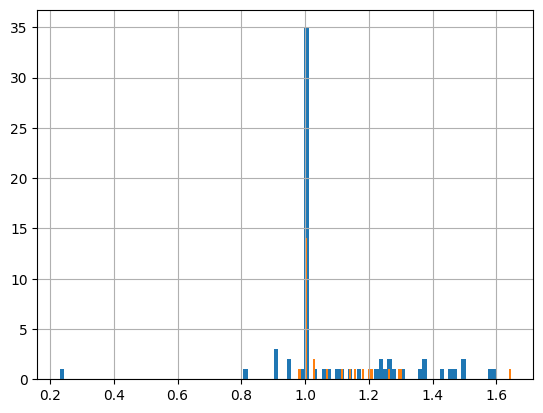

In [29]:
pd.Series([df_rates['ztfg_fade_hwhm']* 2 / df_rates['ztfg_fwhm']]).describe()
pd.Series([df_rates['ztfr_fade_hwhm']* 2 / df_rates['ztfr_fwhm']]).hist(bins=100)
pd.Series([df_rates['ztfi_fade_hwhm']* 2 / df_rates['ztfi_fwhm']]).hist(bins=100)

In [30]:
display(df_rates[df_rates['ztfg_rise_hwhm'].isnull()]['ztfg_fwhm'].describe())
display(df_rates[df_rates['ztfg_rise_hwhm'].notnull()]['ztfg_fwhm'].describe())

count    35.000000
mean      7.217704
std       6.101667
min       0.340532
25%       2.875034
50%       5.063536
75%      11.050678
max      22.874986
Name: ztfg_fwhm, dtype: float64

count    34.000000
mean      9.889018
std       8.195035
min       0.989092
25%       3.123890
50%       7.246548
75%      12.523363
max      29.567084
Name: ztfg_fwhm, dtype: float64

,obj_id,type,redshift,ztfg_fwhm_ratio,ztfr_fwhm_ratio,ztfi_fwhm_ratio
0,AT2017gfo,Kilonova,0.009840,1.000000,1.000000,1.000000
1,ZTF18aakuewf,Ibn,0.063600,1.244681,1.241758,NaN
2,ZTF18aalrxas,IIb,0.058200,1.139785,1.377778,NaN
3,ZTF18abffyqp,II,0.031000,1.712121,1.497487,NaN
4,ZTF18abvkmgw,Ib,0.038470,1.384428,1.369738,NaN
...,...,...,...,...,...,...
65,ZTF23abobwsd,IIb,0.024000,1.000000,1.000000,1.000000
66,ZTF23absbqun,Ib,0.010100,1.121622,1.278552,NaN
67,ZTF23abtycgb,II,0.020127,1.000000,1.000000,NaN
68,ZTF24aascytf,II,0.038000,1.235955,1.170149,1.203661


,redshift,ztfg_fwhm_ratio,ztfr_fwhm_ratio,ztfi_fwhm_ratio
count,70.000000,69.000000,68.000000,28.000000
mean,0.151302,1.058145,1.089283,1.093552
std,0.432537,0.237357,0.210425,0.149134
min,0.000000,0.206642,0.231156,0.979079
25%,0.001825,1.000000,1.000000,1.000000
50%,0.025364,1.000000,1.000000,1.000000
75%,0.046367,1.121622,1.228673,1.163507
max,2.900000,1.761194,1.600000,1.645161


<Axes: >

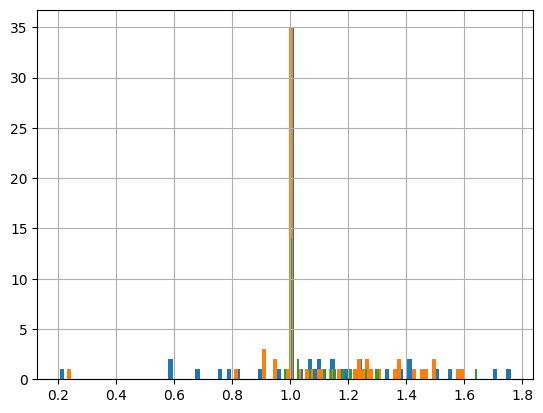

In [31]:
df_compare = pd.DataFrame()
df_compare['obj_id'] = df_rates['obj_id']
df_compare['type'] = df_rates['type']
df_compare['redshift'] = df_rates['redshift']
df_compare['ztfg_fwhm_ratio'] = (df_rates['ztfg_fade_hwhm']* 2) / df_rates['ztfg_fwhm']
df_compare['ztfr_fwhm_ratio'] = (df_rates['ztfr_fade_hwhm']* 2) / df_rates['ztfr_fwhm']
df_compare['ztfi_fwhm_ratio'] = (df_rates['ztfi_fade_hwhm']* 2 )/ df_rates['ztfi_fwhm']
df_compare.loc[df_compare['ztfg_fwhm_ratio'] == 2, 'ztfg_fwhm_ratio'] = np.nan
df_compare.loc[df_compare['ztfr_fwhm_ratio'] == 2, 'ztfr_fwhm_ratio'] = np.nan
df_compare.loc[df_compare['ztfi_fwhm_ratio'] == 2, 'ztfi_fwhm_ratio'] = np.nan

display(df_compare)
display(df_compare.describe())

df_compare['ztfg_fwhm_ratio'].hist(bins=100)
df_compare['ztfr_fwhm_ratio'].hist(bins=100)
df_compare['ztfi_fwhm_ratio'].hist(bins=100)

In [32]:
df_rates.to_csv('gp_objects_rates.csv', index=False)